<a href="https://colab.research.google.com/github/Nilufayeasmin299/Covid19_US_data-for-Twitter_sentiment-analysis/blob/main/Covid19_US_data_for_SA_with_200_dim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
#Read csv file
df=pd.read_csv('/content/gdrive/My Drive/project for paper /dataset/tencities_15days_april.csv')
df.head()

,twitteDate,tweet_id,created_at,text,loc,user_id,verified,CleanedText,Subjectivity,Polarity,Analysis
0,2020-04-01,1245138809454395392,2020-04-01 00:00:00+00:00,thebsimone during corona stay clean fuck free ...,CA,u282394,0,thebsimon corona stay clean fuck free manit ki...,0.733333,-0.005556,Negative
1,2020-04-01,1245138809920126983,2020-04-01 00:00:00+00:00,balance joining fight against corona turning s...,CA,u460114,0,balanc join fight corona turn shoe product med...,0.000000,0.000000,Neutral
2,2020-04-01,1245138828622471168,2020-04-01 00:00:04+00:00,tory lanez asked young thug been staying coron...,WA,u127769,0,tori lanez ask young thug stay coronafre respo...,0.400000,0.100000,Positive
3,2020-04-01,1245138837057216518,2020-04-01 00:00:06+00:00,hasanthehun donald trump already trying spin c...,FL,u457103,0,hasanthehun donald trump alreadi tri spin coro...,0.000000,0.000000,Neutral
4,2020-04-01,1245138844766416896,2020-04-01 00:00:08+00:00,ghastly corona found into life affected family...,TX,u616396,0,ghast corona found life affect famili lost ano...,0.000000,0.000000,Neutral


Let's now see the distribution of sentiments across all the tweets.

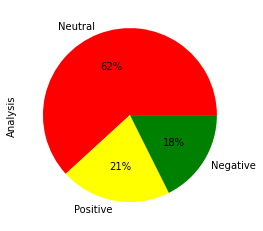

In [ ]:
df.Analysis.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

In [ ]:
df.columns

Index(['twitteDate', 'tweet_id', 'created_at', 'text', 'loc', 'user_id',
       'verified', 'CleanedText', 'Subjectivity', 'Polarity', 'Analysis'],
      dtype='object')

In [ ]:
data=df.drop(['twitteDate','tweet_id','created_at','text','loc','user_id','verified','Subjectivity','Polarity'],axis=1)

In [ ]:
data.head()

,CleanedText,Analysis
0,thebsimon corona stay clean fuck free manit ki...,Negative
1,balanc join fight corona turn shoe product med...,Neutral
2,tori lanez ask young thug stay coronafre respo...,Positive
3,hasanthehun donald trump alreadi tri spin coro...,Neutral
4,ghast corona found life affect famili lost ano...,Neutral


In [ ]:
#Here we make our X value which will then be fitted to scikit learning training test split model
X= data['CleanedText'].values
X.shape

(823002,)

In [ ]:
# Creat the function to get label of the dataset
def getSentiment(Analysis):
    if Analysis== 'Negative':
        return 0
    elif Analysis == 'Positive':
        return 1
    else:
      return 2
data['Sentiment']=data['Analysis'].apply(getSentiment)

In [ ]:
data.head()

,CleanedText,Analysis,Sentiment
0,thebsimon corona stay clean fuck free manit ki...,Negative,0
1,balanc join fight corona turn shoe product med...,Neutral,2
2,tori lanez ask young thug stay coronafre respo...,Positive,1
3,hasanthehun donald trump alreadi tri spin coro...,Neutral,2
4,ghast corona found life affect famili lost ano...,Neutral,2


In [ ]:
y= data['Sentiment'].values
y.shape

(823002,)

In [ ]:
# spliting the dataset into train and test


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(658401,) (164601,) (658401,) (164601,)


**Preparing the Embedding Layer**

In [ ]:
#importing all necessary libraries 
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.layers.core import Dense, Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalMaxPooling1D
from keras.models import Sequential
from keras import regularizers
from keras.preprocessing.sequence import pad_sequences

In [ ]:
from keras.preprocessing.text import Tokenizer
# we will use the 'Tokenizer' class from the 'keras.preprocessing.text' module to create a word-to-index dictionary.
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 500

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
embeddings_dictionary = dict()
glove_file = open('/content/gdrive/My Drive/project for paper /dataset/glove.6B.200d.txt', encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, 200))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

**Build LTSM model for sentiment analysis**

In [ ]:
num_labels = 3
from keras.layers import LSTM
#Defining LTSM model:
model = Sequential()
embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(LSTM(100))
model.add(Dense(num_labels, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 200)          73043400  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               120400    
_________________________________________________________________
dense (Dense)                (None, 3)                 303       
Total params: 73,164,103
Trainable params: 120,703
Non-trainable params: 73,043,400
_________________________________________________________________


In [ ]:
BATCH_SIZE = 128
NUM_EPOCHS = 3

**Fit LTSM model**

In [ ]:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=0.2)

Epoch 1/3
4115/4115 [==============================] - 5668s 1s/step - loss: 0.9309 - acc: 0.6173 - val_loss: 0.9294 - val_acc: 0.6174
Epoch 2/3
4115/4115 [==============================] - 5737s 1s/step - loss: 0.9298 - acc: 0.6174 - val_loss: 0.9294 - val_acc: 0.6174
Epoch 3/3
4115/4115 [==============================] - 5640s 1s/step - loss: 0.9296 - acc: 0.6174 - val_loss: 0.9294 - val_acc: 0.6174


**Evaluate LTSM model**

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

5144/5144 [==============================] - 575s 112ms/step - loss: 0.9262 - acc: 0.6202


**Build CNN model for sentiment analysis**

In [ ]:
#Defining CNN model
model = Sequential()

embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(num_labels, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 200)          73043400  
_________________________________________________________________
conv1d (Conv1D)              (None, 496, 128)          128128    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 73,171,915
Trainable params: 128,515
Non-trainable params: 73,043,400
_________________________________________________________________


**Fit CNN model**

In [ ]:
#Let's now train our model:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=0.2)

Epoch 1/3
4115/4115 [==============================] - 3181s 773ms/step - loss: 0.1620 - acc: 0.9494 - val_loss: 0.0823 - val_acc: 0.9802
Epoch 2/3
4115/4115 [==============================] - 3156s 767ms/step - loss: 0.0636 - acc: 0.9848 - val_loss: 0.0670 - val_acc: 0.9838
Epoch 3/3
4115/4115 [==============================] - 3183s 774ms/step - loss: 0.0477 - acc: 0.9889 - val_loss: 0.0644 - val_acc: 0.9854


**Evaluate CNN model**

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

5144/5144 [==============================] - 391s 76ms/step - loss: 0.0625 - acc: 0.9857
